# 3.1 Data Preparation

In [2]:
#setup path
path = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
import sys; sys.path.append(path)

#standard imports
import numpy as np
import pandas as pd
import datetime
from scipy import stats
from collections import OrderedDict

#third party imports
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import rcParams
import seaborn as sns

#local imports
import analysis.dataPreparer as dp
import analysis.getStages as gs

#constants
input_path = path+"analysis/input/master.db"
flatten_config = path+"analysis/config/master_feature.sql"
raw_flat_file = path+"analysis/output/temp/raw.csv"
clean_flat_file = path+"analysis/output/temp/clean.csv"
output_path = path+"analysis/output/temp/output.db"

#setup
%matplotlib inline
rcParams['figure.figsize'] = 20,6
sns.set_style("whitegrid")

#dp.flatten_file(input_path, flatten_config, raw_flat_file, "feature")
#dp.clean_file(raw_flat_file, clean_flat_file)
#dp.load_file(output_path, clean_flat_file, "feature")
df = dp.export_dataframe(output_path, "feature")
df_backup = df.copy()

logManager - INFO - export_dataframe | Started
logManager - INFO - export_dataframe | Passed | 171.69


In [99]:
#reload data from memory
df = df_backup

In [31]:
#df = df.sample(1000)

In [100]:
import analysis.getStages as gs
gs.create_stages(df)
print("Stages done.")

Stages done.


## 3.1.3 Preliminary Screening

In [101]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

New             276305
Other            61265
Acquired         26894
Seed             24910
Pre-Seed          9279
Series A          8580
IPO               5800
Series B          4584
Closed            3279
Series D+/PE      2881
Series C          2157
Name: keys_company_stage, dtype: int64
New             0.648704
Other           0.143837
Acquired        0.063141
Seed            0.058483
Pre-Seed        0.021785
Series A        0.020144
IPO             0.013617
Series B        0.010762
Closed          0.007698
Series D+/PE    0.006764
Series C        0.005064
Name: keys_company_stage, dtype: float64
425934


Removed Other, Closed, Acquired & IPO groups

In [102]:
df = df.loc[df["keys_company_stage"] != "Other"]
df = df.loc[df['keys_company_stage_group'] != "Excluded"]

In [103]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

New             276305
Seed             24910
Pre-Seed          9279
Series A          8580
Series B          4584
Series D+/PE      2881
Series C          2157
Name: keys_company_stage, dtype: int64
New             0.840610
Seed            0.075784
Pre-Seed        0.028230
Series A        0.026103
Series B        0.013946
Series D+/PE    0.008765
Series C        0.006562
Name: keys_company_stage, dtype: float64
328696


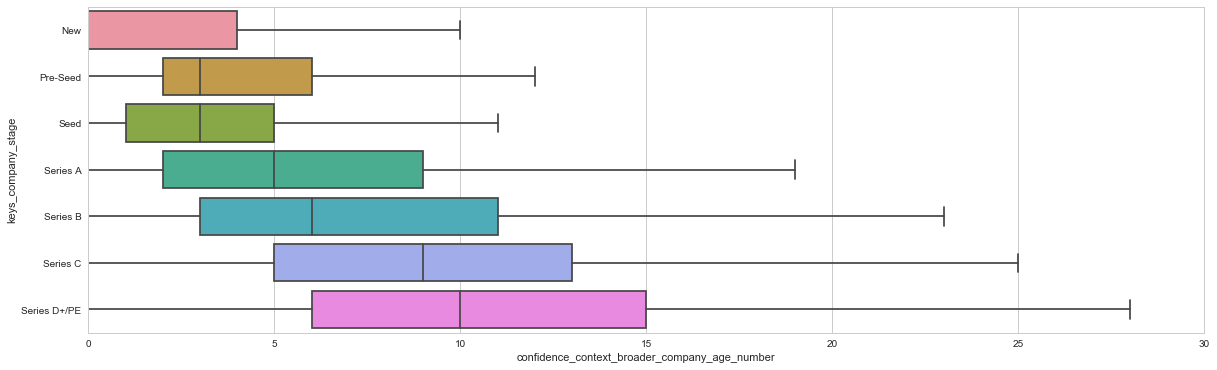

In [104]:
order_1 = ["New", "Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+/PE"]

f, ax = plt.subplots()
ax.set_xlim(xmax=30)
sns.boxplot(
    x="confidence_context_broader_company_age_number", 
    y="keys_company_stage",
    order=order_1,data=df, fliersize=0, ax=ax)

Removed companies older than 15 years old

In [105]:
df = df.loc[df['confidence_context_broader_company_age_number'] <= 15]

In [106]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

New             276305
Seed             24592
Pre-Seed          8850
Series A          7966
Series B          4028
Series D+/PE      2179
Series C          1802
Name: keys_company_stage, dtype: int64
New             0.848285
Seed            0.075500
Pre-Seed        0.027170
Series A        0.024456
Series B        0.012366
Series D+/PE    0.006690
Series C        0.005532
Name: keys_company_stage, dtype: float64
325722


## 3.1.4 Descriptive Statistics

Table 3. Final test dataset counts grouped by lifecycle stage.

In [118]:
drops = [col for col in list(df) if col.startswith(("key","from","outcome","index"))]
X = df.drop(drops, axis=1)
X = X.select_dtypes(['number'])

In [119]:
df["keys_missing_features"] = X.isnull().sum(axis=1)
len(list(df))

479

In [120]:
groups = [df["keys_company_stage"]]
columns = ["keys_company_stage", "confidence_context_broader_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "keys_missing_features"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)", "Available Features (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: len(list(df)) - np.median(x)), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") )])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

order_1 = ["New", "Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+/PE"]

tab = df[columns].groupby(groups)
tab = tab.agg(aggfunc)
tab.rename(columns=namefunc)

Obs Age (Years)      Funding Raised (USD, millions)  \
                         N      Median  IQR                         Median   
keys_company_stage                                                           
New                 276305         0.0  4.0                       0.000000   
Pre-Seed              8850         3.0  3.0                       0.045571   
Seed                 24592         3.0  4.0                       0.165000   
Series A              7966         4.0  5.0                       4.000000   
Series B              4028         6.0  6.0                      14.000000   
Series C              1802         7.0  7.0                      31.635000   
Series D+/PE          2179         8.0  7.0                      45.500000   

                              Funding Rounds (N)      Available Features (N)  \
                          IQR             Median  IQR                 Median   
keys_company_stage                                                             
New                  0.000000                0.0  0.0                    276   
Pre-Seed             0.405649                1.0  0.0                    319   
Seed                 0.882000                1.0  1.0                    329   
Series A             7.709528                2.0  1.0                    341   
Series B            20.706003                2.0  2.0                    349   
Series C            45.297500                3.0  2.0                    357   
Series D+/PE        93.585828                3.0  4.0                    353   

                           
                      IQR  
keys_company_stage         
New                 24.00  
Pre-Seed            30.00  
Seed                36.00  
Series A            39.75  
Series B            43.00  
Series C            41.00  
Series D+/PE        50.00

In [121]:
groups = [df["keys_company_stage_group"]]
columns = ["keys_company_stage", "confidence_context_broader_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "keys_missing_features"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)", "Available Features (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median), ("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]),
    OrderedDict([("Median", lambda x: len(list(df)) - np.median(x)), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") )])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

tab = df[columns].groupby(groups)
tab = tab.agg(aggfunc)
tab.rename(columns=namefunc)

Obs Age (Years)       \
                               N      Median  IQR   
keys_company_stage_group                            
Included                  325722         1.0  5.0   

                         Funding Raised (USD, millions)       \
                                                 Median  IQR   
keys_company_stage_group                                       
Included                                            0.0  0.0   

                         Funding Rounds (N)      Available Features (N)      
                                     Median  IQR                 Median IQR  
keys_company_stage_group                                                     
Included                                0.0  0.0                    278  37

Table 3. Final test dataset counts grouped by company sector.

[53575, 43638, 31229, 21835, 20598, 18743, 14851, 14032, 13166, 12718]


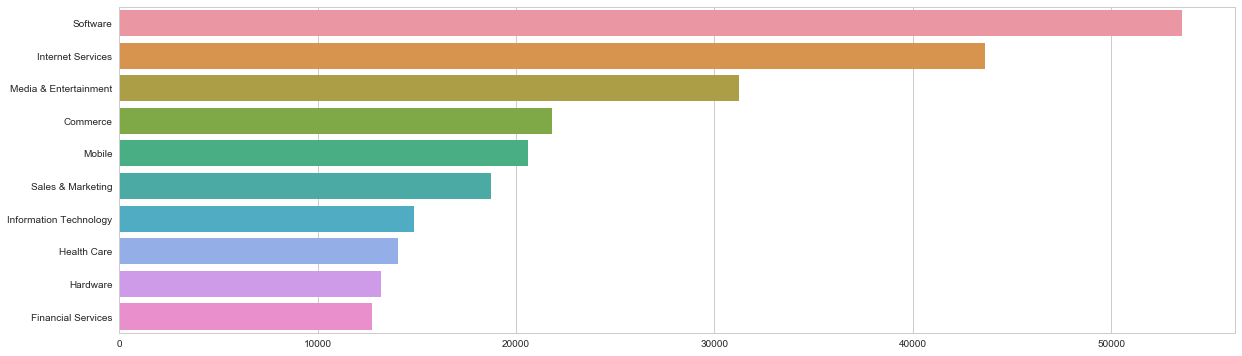

In [122]:
industries = [x for x in list(df) if x.startswith("confidence_context_industry_category_group_list")]
values = [df[industry].value_counts()[1] for industry in industries]
values = sorted(values,reverse=True)
print(values)
names = ["Software", "Internet Services", "Media & Entertainment", "Commerce", "Mobile", "Sales & Marketing", "Information Technology", "Health Care", "Hardware", "Financial Services"]
sns.barplot(x = values, y = names, order = names)

# 3.2 Pre-Processing

## 3.2.1 Imputation

(!) Figure 3. Number of missing features per observation (histogram).

[(0, 231.25000000000003)]

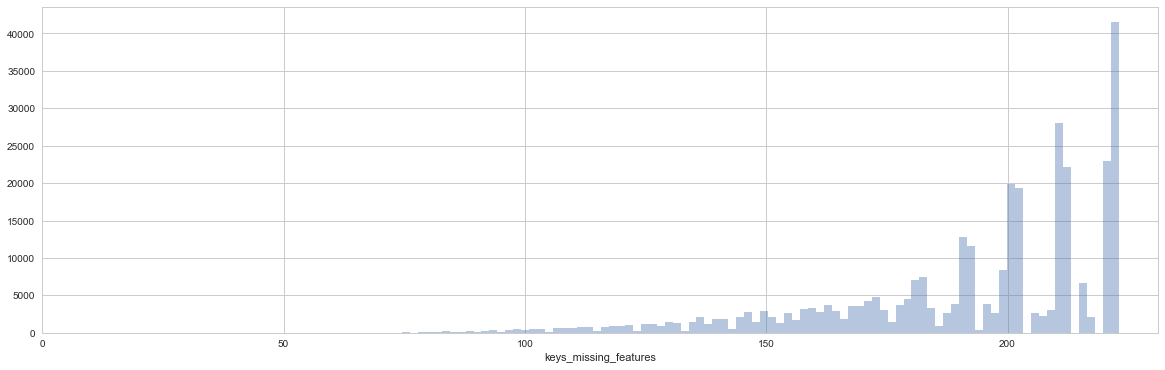

In [123]:
g = sns.distplot(df["keys_missing_features"], bins=100, kde=False)
g.set(xlim = (0,None))

(!) Figure 3. Number of missing observations per feature (histogram).

[(0, 342008.10000000003)]

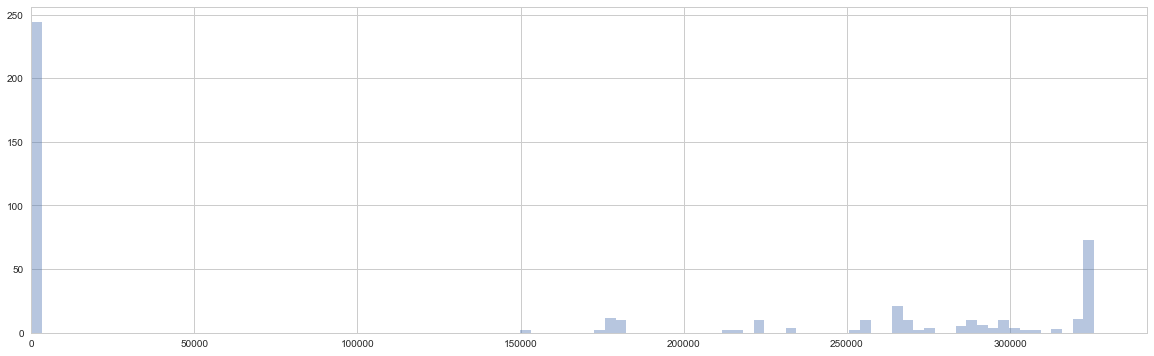

In [124]:
missing_by_col =  X.isnull().sum(axis=0)
g = sns.distplot(missing_by_col, bins=100, kde=False)
g.set(xlim = (0,None))

Figure 3. Mean, median and mode of features (grouped bar plot).

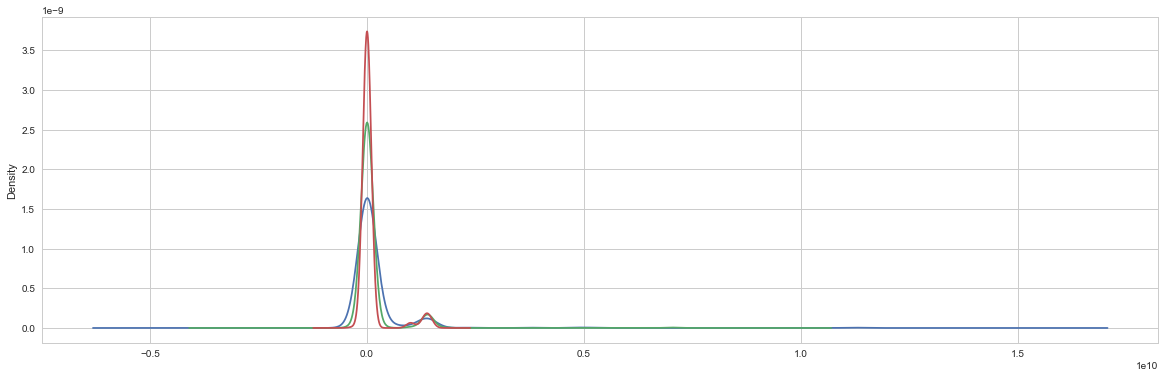

In [125]:
means_by_col = X.mean(axis=0)#.dropna()
means_by_col.plot(kind="kde", label="Mean")

medians_by_col = X.median(axis=0)#.dropna()
medians_by_col.plot(kind="kde", label="Median")

modes_by_col = X.mode(axis=0).T[0]
modes_by_col.plot(kind="kde",label="Mode")

Figure 3. ROC Curve for different imputations - mean, median, mode (line plot).

## 3.2.2 Transformation

--> Apply Imputation

In [133]:
from sklearn.preprocessing import Imputer

X = X.dropna(axis=1, how = "all")
imp = Imputer(strategy="median")
X_imp = imp.fit_transform(X)
X_imp = pd.DataFrame(X_imp, index=X.index, columns=list(X))

--> Shift to positive numbers only

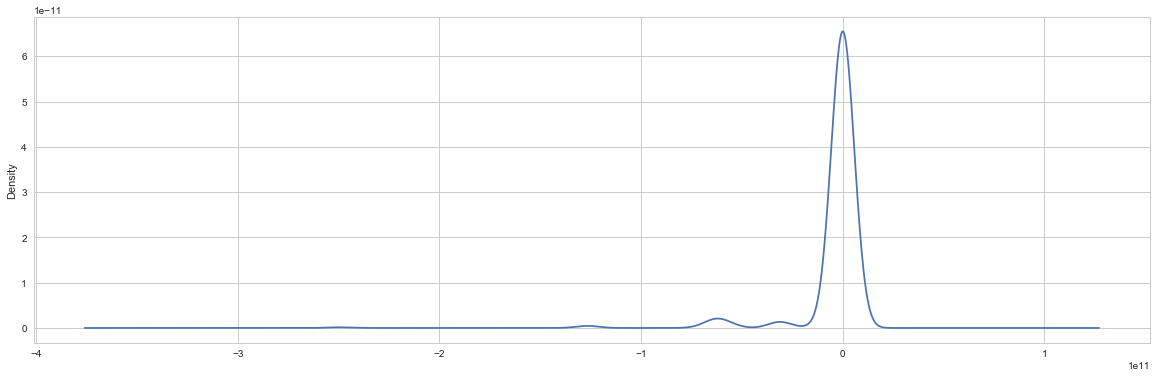

In [143]:
mins_by_col = X_imp.min(axis=0)#.dropna()
mins_by_col.plot(kind="kde", label="Minimum")

In [167]:
X_pos = X_imp.subtract(X_imp.min(axis=0))
X_pos.describe()

,confidence_context_broader_offices_headquarters_country_dummy_aus,confidence_context_broader_offices_headquarters_country_dummy_bra,confidence_context_broader_offices_headquarters_country_dummy_can,confidence_context_broader_offices_headquarters_country_dummy_deu,confidence_context_broader_offices_headquarters_country_dummy_esp,confidence_context_broader_offices_headquarters_country_dummy_fra,confidence_context_broader_offices_headquarters_country_dummy_gbr,confidence_context_broader_offices_headquarters_country_dummy_ind,confidence_context_broader_offices_headquarters_country_dummy_isr,confidence_context_broader_offices_headquarters_country_dummy_usa,...,potential_human_advisors_companies_operating_advisor_average_number,potential_human_advisors_companies_operating_advisor_total_number,potential_human_advisors_companies_closed_advisor_average_number,potential_human_advisors_companies_closed_advisor_total_number,confidence_context_broader_last_updated_date_to_confidence_context_broader_founded_date_duration,confidence_validation_funding_first_date_to_confidence_context_broader_founded_date_duration,confidence_validation_funding_last_date_to_confidence_context_broader_founded_date_duration,confidence_validation_funding_first_date_to_confidence_context_broader_last_updated_date_duration,confidence_validation_funding_last_date_to_confidence_context_broader_last_updated_date_duration,confidence_validation_funding_last_date_to_confidence_validation_funding_first_date_duration
count,325722.000000,325722.000000,325722.000000,325722.000000,325722.000000,325722.000000,325722.000000,325722.000000,325722.000000,325722.000000,...,325722.000000,325722.000000,325722.000000,325722.000000,3.257220e+05,3.257220e+05,3.257220e+05,3.257220e+05,3.257220e+05,3.257220e+05
mean,0.012864,0.009766,0.021807,0.011952,0.012293,0.009834,0.040139,0.035570,0.007915,0.837862,...,0.427917,0.811133,0.005260,0.010948,3.444990e+08,4.533161e+08,4.258197e+08,1.083560e+08,8.640222e+07,5.037020e+08
std,0.112687,0.098339,0.146053,0.108670,0.110189,0.098676,0.196284,0.185216,0.088612,0.368578,...,1.824389,4.136556,0.073903,0.139790,6.891021e+07,2.927875e+07,3.581549e+07,4.862788e+07,4.684211e+07,2.481279e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,3.475172e+08,4.567104e+08,4.295808e+08,1.026669e+08,8.032945e+07,5.085504e+08
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,3.498148e+08,4.567104e+08,4.295808e+08,1.026669e+08,8.032945e+07,5.085504e+08
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,3.591362e+08,4.567104e+08,4.295808e+08,1.026669e+08,8.032945e+07,5.085504e+08
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,49.000000,294.000000,4.000000,7.000000,5.346087e+08,9.784800e+08,9.790848e+08,1.063438e+09,1.069087e+09,5.085504e+08


--> Start transformations

Skewness (Original): 164.79
Skewness (BoxCox): 2.02
Skewness (Log1P): 2.15
Skewness (SQRT): 13.13
Skewness (Binary): 2.02


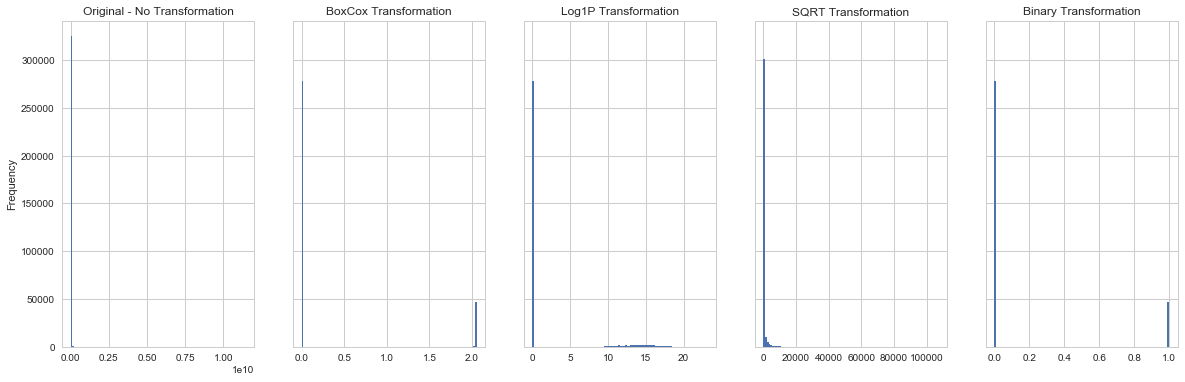

In [205]:
funding = X_pos["confidence_validation_funding_raised_value_total_number"]

figure = plt.figure()

ax0 = plt.subplot(151)
funding.plot(kind="hist", bins=100)
plt.title("Original - No Transformation") 
print("Skewness (Original): {0:.2f}".format(stats.skew(funding))) 

figure.add_subplot(152, sharey=ax0)
boxcox = pd.Series(stats.boxcox(funding + 1)[0], index=X_pos.index)
boxcox.plot(kind="hist", bins=100)
plt.title("BoxCox Transformation") 
print("Skewness (BoxCox): {0:.2f}".format(stats.skew(boxcox))) 

figure.add_subplot(153, sharey=ax0)
log1p = pd.Series(np.log1p(funding), index=X_pos.index)
log1p.plot(kind="hist", bins=100)
plt.title("Log1P Transformation") 
print("Skewness (Log1P): {0:.2f}".format(stats.skew(log1p)))

figure.add_subplot(154, sharey=ax0)
sqrt = pd.Series(funding**(1/2), index=X_pos.index)
sqrt.plot(kind="hist", bins=100)
plt.title("SQRT Transformation") 
print("Skewness (SQRT): {0:.2f}".format(stats.skew(sqrt)))

from sklearn.preprocessing import binarize

figure.add_subplot(155, sharey=ax0)
binary = pd.Series(np.where(funding == 0, 0, 1), index=X_pos.index)
binary.plot(kind="hist", bins=100)
plt.title("Binary Transformation") 
print("Skewness (Binary): {0:.2f}".format(stats.skew(binary)))

--> Apply transformations

In [206]:
from sklearn.preprocessing import FunctionTransformer

ft = FunctionTransformer(np.log1p)
X_tf = ft.fit_transform(X_pos)
X_tf = pd.DataFrame(X_tf, index=X_pos.index, columns=list(X_pos))

--> Start scaling

Median: 0.0, IQR: 0.0
Median: -0.4053973137078973, IQR: 0.0


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:1008: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it cont

Median: 0.0, IQR: 0.0
Median: 0.0, IQR: 0.0


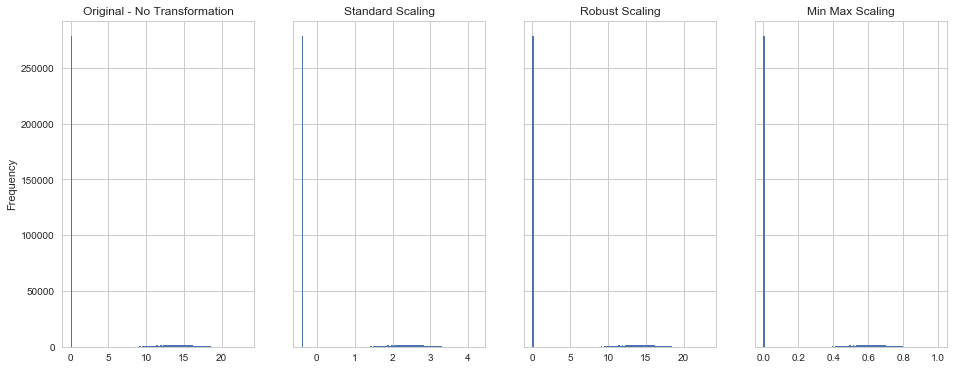

In [211]:
from sklearn.preprocessing import scale, robust_scale, minmax_scale

funding = X_tf["confidence_validation_funding_raised_value_total_number"]

figure = plt.figure()

ax0 = plt.subplot(151)
funding.plot(kind="hist", bins=100)
plt.title("Original - No Transformation") 
print("Median: {}, IQR: {}".format(funding.median(), stats.iqr(funding)))

figure.add_subplot(152, sharey=ax0)
funding_std = pd.Series(scale(funding), index=X_pos.index)
funding_std.plot(kind="hist", bins=100)
plt.title("Standard Scaling") 
print("Median: {}, IQR: {}".format(funding_std.median(), stats.iqr(funding_std)))


figure.add_subplot(153, sharey=ax0)
funding_robust = pd.Series(robust_scale(funding), index=X_pos.index)
funding_robust.plot(kind="hist", bins=100)
plt.title("Robust Scaling") 
print("Median: {}, IQR: {}".format(funding_robust.median(), stats.iqr(funding_robust)))


figure.add_subplot(154, sharey=ax0)
funding_mm = pd.Series(minmax_scale(funding), index=X_pos.index)
funding_mm.plot(kind="hist", bins=100)
plt.title("Min Max Scaling") 
print("Median: {}, IQR: {}".format(funding_mm.median(), stats.iqr(funding_mm)))

--> Apply scaling

In [212]:
from sklearn.preprocessing import scale

X_std = scale(X_tf)
X_std = pd.DataFrame(X_std, index=X_tf.index, columns=list(X_tf))

## 3.2.3 Extraction

PCA Model

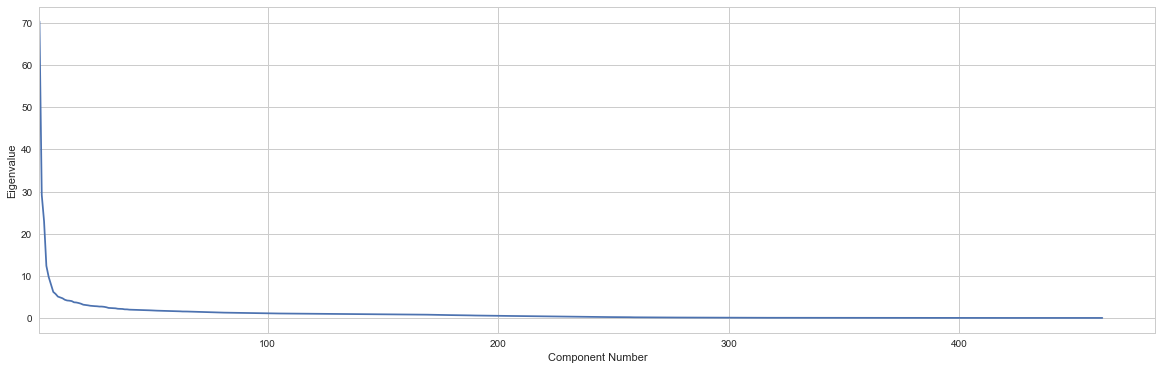

In [260]:
#Principal Components Analysis (PCA)
from sklearn.decomposition import PCA

def screeplot(pca, X):
    y = pca.explained_variance_
    x = np.arange(len(y)) + 1
    plt.plot(x, y)
    plt.ylabel("Eigenvalue")
    plt.xlabel("Component Number")
    plt.xlim(1,None)
    return y

pca = PCA().fit(X_std)
eigenvalues = screeplot(pca,X_std)

Grouped

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2558: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


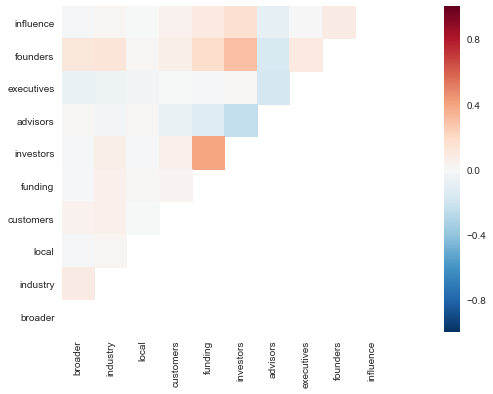

In [253]:
from collections import defaultdict
from itertools import combinations

features = list(X_std)
f_map = {x: '_'.join(x.split("_")[:3]) for x in features}
f_group = defaultdict(list)
for f,g in f_map.items():
    f_group[g].append(f)
agg_group = {}
for g,l in f_group.items():
    combo = combinations(l, 2)
    for x,y in combo:
        corr = stats.spearmanr(X_std[x][:100], X_std[y][:100])[0]
        if corr < 0: X_std[y] *= -1
    tot = X_std[l].sum(axis=1)
    agg_group[g] = tot
X_grp = pd.DataFrame(agg_group)
grp_corr = X_grp.corr(method="spearman")
mask = np.zeros_like(grp_corr)
mask[np.triu_indices_from(mask)] = True
f_names = [x.split("_")[2] for x in list(X_grp)]
ax = sns.heatmap(grp_corr,square=True, mask=mask, xticklabels=f_names, yticklabels=f_names)
ax.invert_yaxis()

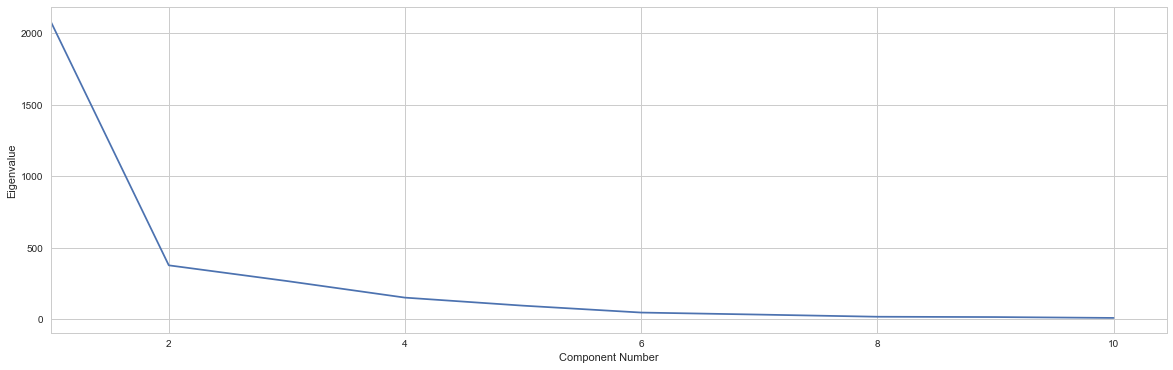

In [261]:
pca = PCA().fit(X_grp)
eigenvalues = screeplot(pca,X_grp)

# 3.3 Classification

# 3.4 Experimentation

## 3.4.2 Robustness

## 3.4.3 Predictive Power